In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mne

/tmp/ipykernel_754480/3624754178.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Reading training and testing csv and parquet files

In [18]:
## Reading training and testing csv files
train_df = pd.read_csv(f'train.csv')[:100]
test_df = pd.read_csv(f'test.csv')


In [19]:
## Parquet File Names
train_df['eeg_path'] = f'train_eegs/'+train_df['eeg_id'].astype(str)+'.parquet'
train_df['spec_path'] = f'train_spectrograms/'+train_df['spectrogram_id'].astype(str)+'.parquet'

test_df['eeg_path'] = f'test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'


In [4]:
## Label Columns *_vote
label_columns = train_df.filter(like="_vote").columns.to_list()

In [5]:
train_df

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0   1628180742           0                       0.0          353733   
1   1628180742           1                       6.0          353733   
2   1628180742           2                       8.0          353733   
3   1628180742           3                      18.0          353733   
4   1628180742           4                      24.0          353733   
..         ...         ...                       ...             ...   
95   893864755           5                      30.0         4367732   
96  3669581453           0                       0.0         4546138   
97  3669581453           1                       4.0         4546138   
98  3669581453           2                       6.0         4546138   
99  1424484930           0                       0.0         4583530   

    spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                    0                               0.0   127492639   
1                    1                               6.0  3887563113   
2                    2                               8.0  1142670488   
3                    3                              18.0  2718991173   
4                    4                              24.0  3080632009   
..                 ...                               ...         ...   
95                   5                              30.0  1523697063   
96                   0                               0.0  3616273655   
97                   1                               4.0  2864762111   
98                   2                               6.0  1822146963   
99                   0                               0.0  2692343476   

    patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0        42516          Seizure             3         0         0          0   
1        42516          Seizure             3         0         0          0   
2        42516          Seizure             3         0         0          0   
3        42516          Seizure             3         0         0          0   
4        42516          Seizure             3         0         0          0   
..         ...              ...           ...       ...       ...        ...   
95        2338            Other             0         0         0          0   
96       57448             LRDA             0         0         0          3   
97       57448             LRDA             0         0         0          3   
98       57448             LRDA             0         0         0          3   
99         840            Other             0         2         0          1   

    grda_vote  other_vote                       eeg_path  \
0           0           0  train_eegs/1628180742.parquet   
1           0           0  train_eegs/1628180742.parquet   
2           0           0  train_eegs/1628180742.parquet   
3           0           0  train_eegs/1628180742.parquet   
4           0           0  train_eegs/1628180742.parquet   
..        ...         ...                            ...   
95          3          10   train_eegs/893864755.parquet   
96          0           0  train_eegs/3669581453.parquet   
97          0           0  train_eegs/3669581453.parquet   
98          0           0  train_eegs/3669581453.parquet   
99          0          12  train_eegs/1424484930.parquet   

                             spec_path  
0    train_spectrograms/353733.parquet  
1    train_spectrograms/353733.parquet  
2    train_spectrograms/353733.parquet  
3    train_spectrograms/353733.parquet  
4    train_spectrograms/353733.parquet  
..                                 ...  
95  train_spectrograms/4367732.parquet  
96  train_spectrograms/4546138.parquet  
97  train_spectrograms/4546138.parquet  
98  train_spectrograms/4546138.parquet  
99  train_spectrograms/4583530.parquet  

[100 rows x 17 columns]

## Adding corresponding 50s eeg and 10min spectogram to each row of training dataframe

In [6]:
unique_eeg_ids = train_df['eeg_id'].unique()
unique_spec_ids = train_df['spectrogram_id'].unique()

In [20]:
train_eegs = dict()
train_df['eeg'] = ""

for i in unique_eeg_ids:
    fn = f'train_eegs/'+i.astype(str)+'.parquet'
    train_eegs[i] = pd.read_parquet(fn)

eeg_channel_names = train_eegs[train_df['eeg_id'][0]].columns


In [21]:
train_specs = dict()
train_df['spec'] = ""

for i in unique_spec_ids:
   fn = f'train_spectrograms/'+i.astype(str)+'.parquet'
   train_specs[i] = pd.read_parquet(fn)
spec_channel_names = train_specs[train_df['spectrogram_id'][0]].columns

In [18]:
y = train_eegs[train_df['eeg_id'][0]]

In [24]:
train_specs[train_df['spectrogram_id'][0]]

time  LL_0.59  LL_0.78  LL_0.98  LL_1.17  LL_1.37    LL_1.56    LL_1.76  \
0       1     4.26    10.98     9.05    13.65    11.49   8.930000  18.840000   
1       3     2.65     3.97    12.18    13.26    14.21  13.230000   9.650000   
2       5     4.18     4.53     8.77    14.26    13.36  16.559999  19.219999   
3       7     2.41     3.21     4.92     8.07     5.97  12.420000  10.820000   
4       9     2.29     2.44     2.77     4.62     5.39   7.080000   9.840000   
..    ...      ...      ...      ...      ...      ...        ...        ...   
315   631     6.36     6.59     6.60     7.30     4.48   8.400000  13.420000   
316   633     4.90     8.80     8.22     5.83    10.21  10.580000  10.250000   
317   635     6.07     7.85    11.26     9.20     8.18   9.130000  10.450000   
318   637     3.41     3.75     4.80     6.45     6.70   7.960000   8.160000   
319   639     2.88     3.71     4.02     6.07     5.63   5.460000   6.270000   

     LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  \
0      19.26  19.240000  ...      0.31      0.17      0.28      0.19   
1       8.11  11.280000  ...      0.15      0.13      0.14      0.24   
2      17.51  22.650000  ...      0.29      0.21      0.16      0.25   
3      14.96  21.809999  ...      0.33      0.51      0.49      0.64   
4      12.27  14.410000  ...      0.44      0.38      0.48      0.63   
..       ...        ...  ...       ...       ...       ...       ...   
315    13.85  16.010000  ...      0.14      0.05      0.06      0.04   
316    13.68  19.549999  ...      0.16      0.08      0.06      0.06   
317    15.09  23.020000  ...      0.15      0.13      0.13      0.13   
318     6.97   9.700000  ...      0.13      0.11      0.13      0.07   
319     4.99   6.220000  ...      0.16      0.13      0.14      0.16   

     RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0        0.24      0.27      0.29      0.16      0.22      0.19  
1        0.24      0.36      0.35      0.31      0.36      0.40  
2        0.28      0.28      0.34      0.48      0.44      0.48  
3        0.58      0.42      0.32      0.31      0.32      0.33  
4        0.45      0.45      0.49      0.33      0.31      0.34  
..        ...       ...       ...       ...       ...       ...  
315      0.04      0.04      0.05      0.05      0.08      0.11  
316      0.07      0.04      0.06      0.09      0.07      0.08  
317      0.10      0.08      0.07      0.09      0.17      0.12  
318      0.11      0.12      0.09      0.16      0.19      0.19  
319      0.12      0.12      0.11      0.09      0.07      0.05  

[320 rows x 401 columns]

In [9]:
for i in range(len(train_df)):
    start = (train_df['eeg_label_offset_seconds'][i]*200).astype(int)
    end = start + 200*50
    train_df['eeg'][i] = train_eegs[train_df['eeg_id'][i]].iloc[start:end].to_numpy()


/tmp/ipykernel_754480/2137557950.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['eeg'][i] = train_eegs[train_df['eeg_id'][i]].iloc[start:end].to_numpy()
/tmp/ipykernel_754480/2137557950.py:4: SettingWithCopyWarning: 
A value is

In [24]:
for i in range(len(train_df)):
   start = (train_df['spectrogram_label_offset_seconds'][i])
   if start%2 == 0:
       start +=1
   end = start + 600
   train_df['spec'][i] = train_specs[train_df['spectrogram_id'][i]].iloc[start:end].to_numpy()
    

## Summarized train eeg and spectogram data with votes

In [11]:
train_final_data = train_df.drop(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id', 'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id', 'patient_id', 'eeg_path', 'spec_path'], axis = 1)

In [16]:
train_final_data['eeg'][0].shape

(10000, 20)

## Preprocessing 

In [27]:
## EEG Info for Preprocessing

x = ['eeg']*19
x.append('ecg')

info = mne.create_info(ch_names=eeg_channel_names.tolist(), sfreq=200,
                                        ch_types=x,
                                        verbose=False)

# For one sample (For multiple samples, see below)

In [28]:
for i in range(1):
    Xnp = train_final_data['eeg'][i]

    raw = mne.io.RawArray(data=Xnp.T, info=info, verbose=False)
    raw.set_montage('standard_1005', on_missing='warn');
    

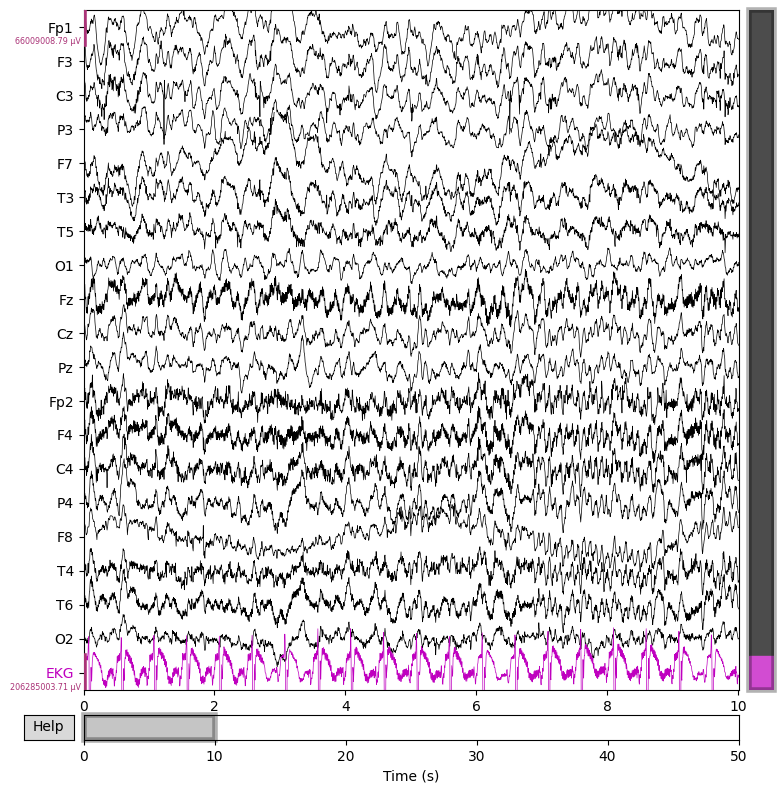

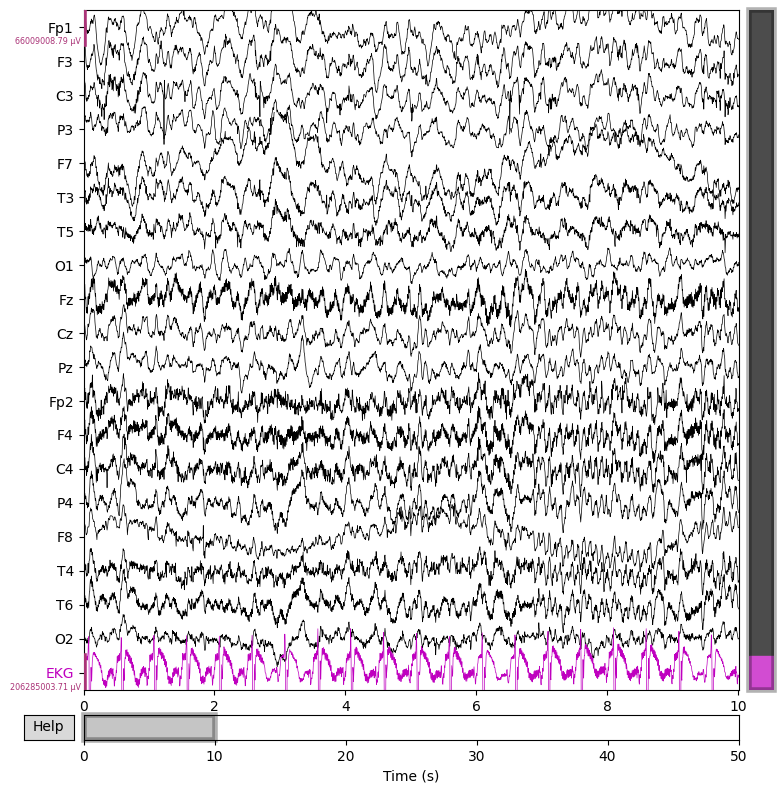

In [30]:
raw.plot(scalings='auto')

In [31]:
raw_filt = raw.copy().filter(0.5,80,verbose=False)


In [32]:
## TODO: Check this (not doing anything)

ssp_projectors = raw_filt.info["projs"]
raw_filt.del_proj()

<RawArray | 20 x 10000 (50.0 s), ~1.6 MB, data loaded>

In [33]:
fig = raw.compute_psd(tmax=np.inf, fmax=100).plot(
    average=True, picks="data", exclude="bads"
)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(
            x=freqs[idx],
            y=psds[idx] + 18,
            dx=0,
            dy=-12,
            color="red",
            width=0.1,
            head_width=3,
            length_includes_head=True,
        )

Effective window size : 10.240 (s)


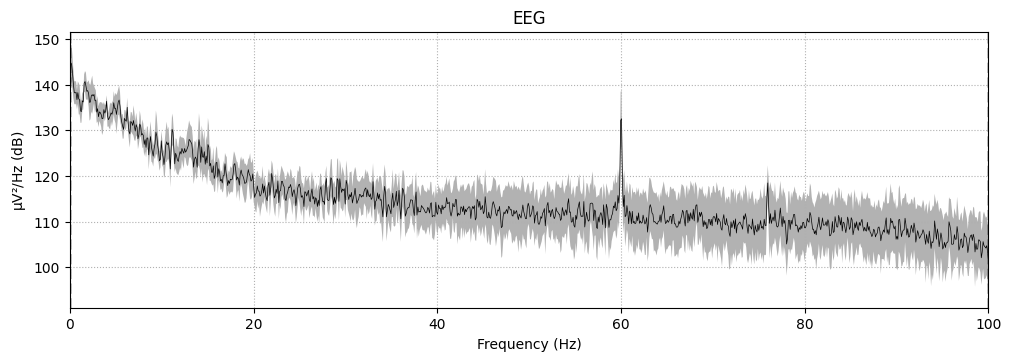

In [34]:
plt.show()

Using channel EKG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2000 samples (10.000 s)

Number of ECG events detected : 96 (average pulse 115 / min.)
Not setting metadata
96 matching events found
No baseline correction applied
Using data from preloaded Raw for 96 events and 201 original time points ...
1 bad epochs dropped
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


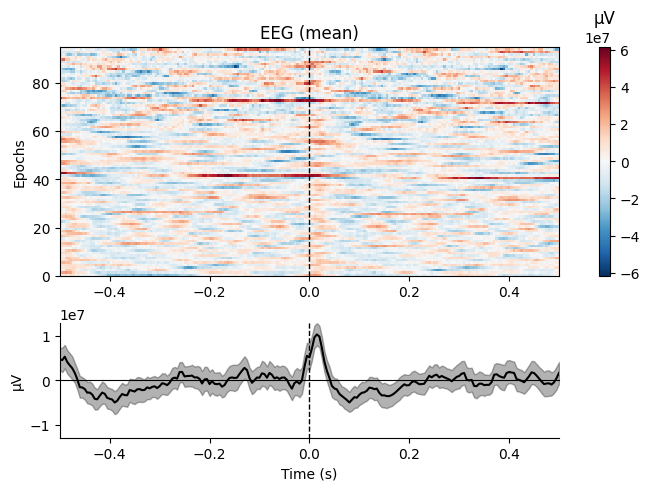

[<Figure size 640x480 with 3 Axes>]

In [35]:
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw_filt)
ecg_epochs.plot_image(combine="mean")

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 10 components


Fitting ICA took 0.4s.


/home/tony/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


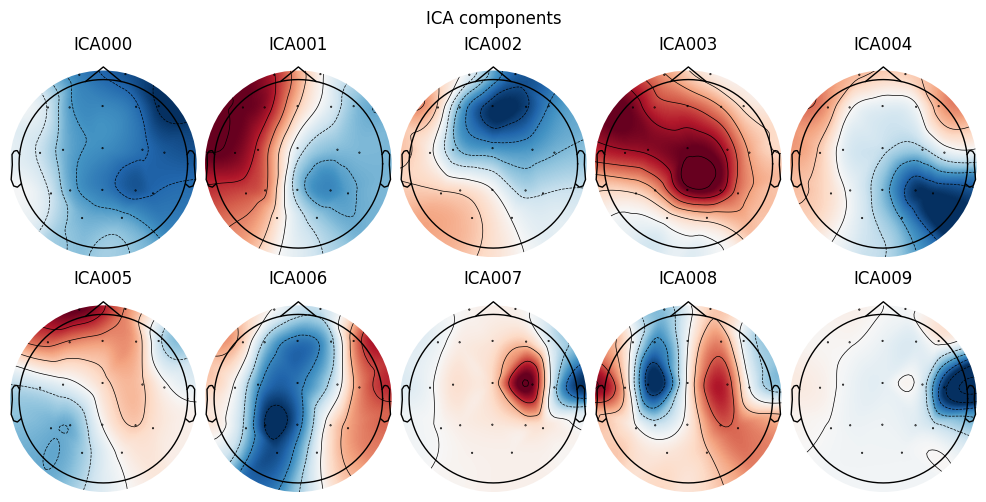

In [36]:
ica = mne.preprocessing.ICA(n_components=10, random_state=97) #change n_components
ica.fit(raw_filt)
ica.plot_components();

Using threshold: 0.36 for CTPS ECG detection
Using channel EKG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2000 samples (10.000 s)

Number of ECG events detected : 96 (average pulse 115 / min.)
Not setting metadata
96 matching events found
No baseline correction applied
Using data from preloaded Raw for 96 events and 201 original time points ...
1 bad epochs dropped


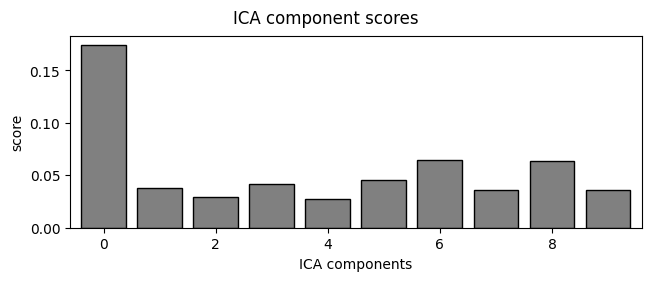

In [37]:
## For EOG artifacts
#eog_indices, eog_scores = ica.find_bads_eog(raw)#, eog_events=eog_events)
#ica.plot_scores(eog_scores)
# For ECG artifacts
ecg_indices, ecg_scores = ica.find_bads_ecg(raw_filt)#, ecg_events=ecg_events)
ica.plot_scores(ecg_scores);



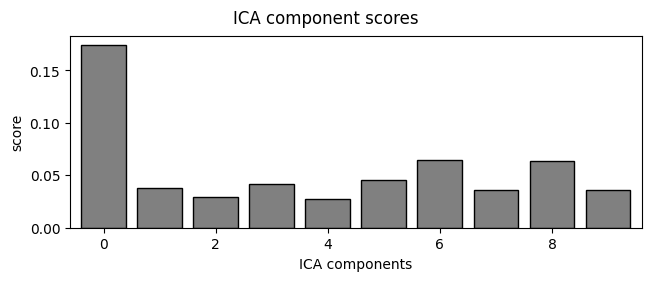

In [38]:
ica.exclude.extend(ecg_indices)
ica.plot_scores(ecg_scores)

In [39]:
raw_ica = ica.apply(raw_filt)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


Creating RawArray with float64 data, n_channels=11, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.


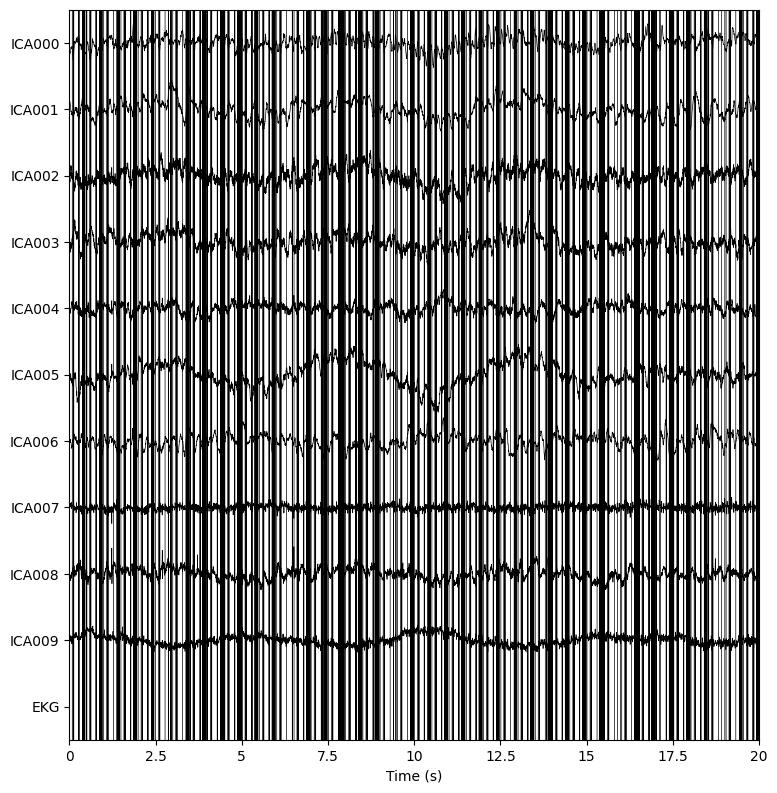

In [40]:
ica.plot_sources(raw, show_scrollbars=False, show=True);

In [41]:
raw_final_filt = raw_ica.notch_filter(freqs=50, filter_length='auto', phase='zero')
raw_final_filt = raw_final_filt.notch_filter(freqs=60, filter_length='auto', phase='zero')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


# Original Raw vs MNE Preprocessed Raw

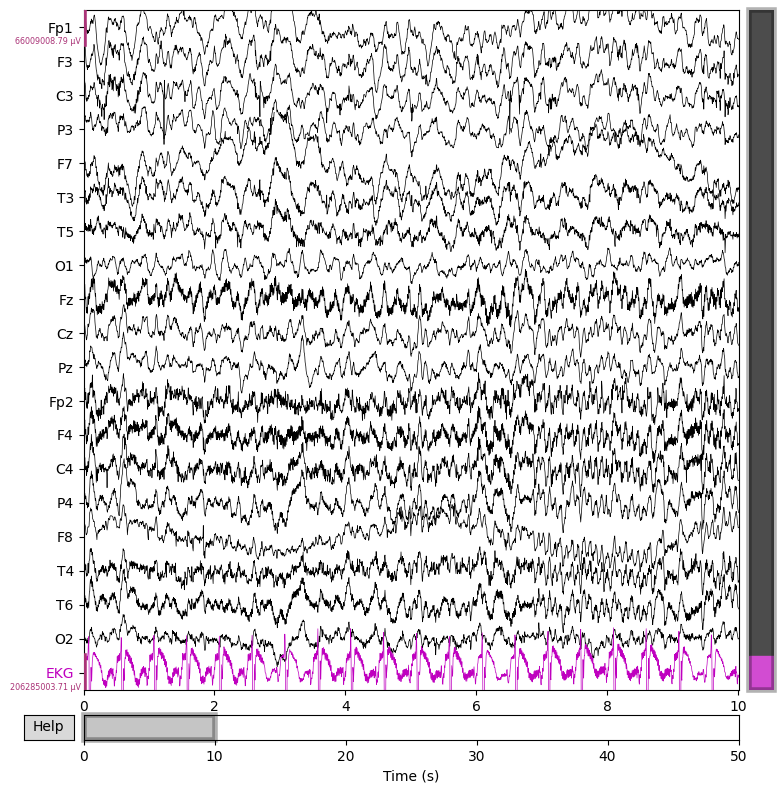

In [42]:
raw.plot(scalings='auto');

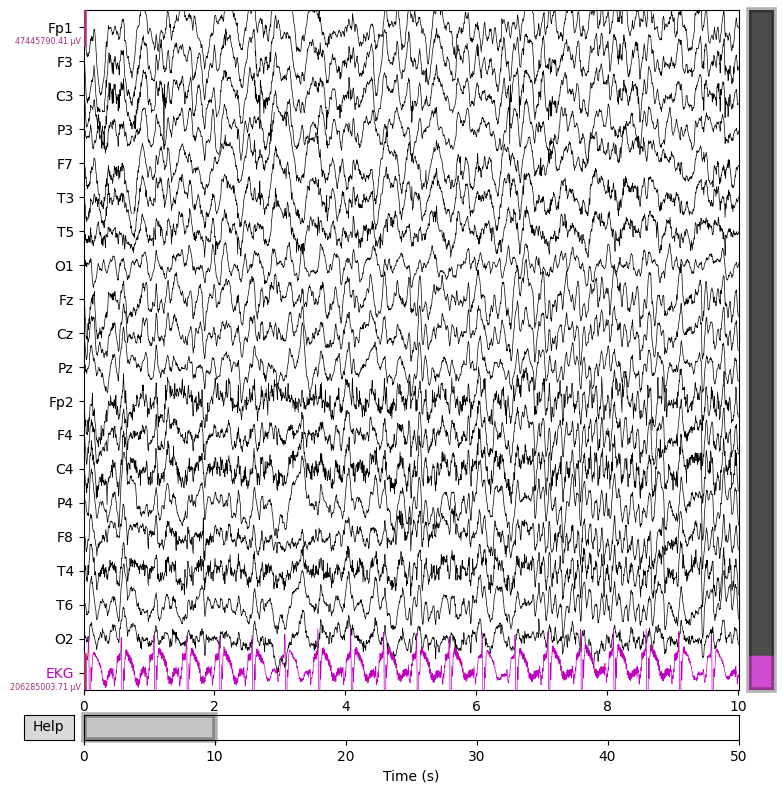

In [43]:
raw_final_filt.plot(scalings='auto');

## Preprocessing multiple samples

In [44]:
train_final_data['eeg_filt'] = ""

Using channel EKG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2000 samples (10.000 s)



Number of ECG events detected : 96 (average pulse 115 / min.)
Not setting metadata
96 matching events found
No baseline correction applied
Using data from preloaded Raw for 96 events and 201 original time points ...
1 bad epochs dropped
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


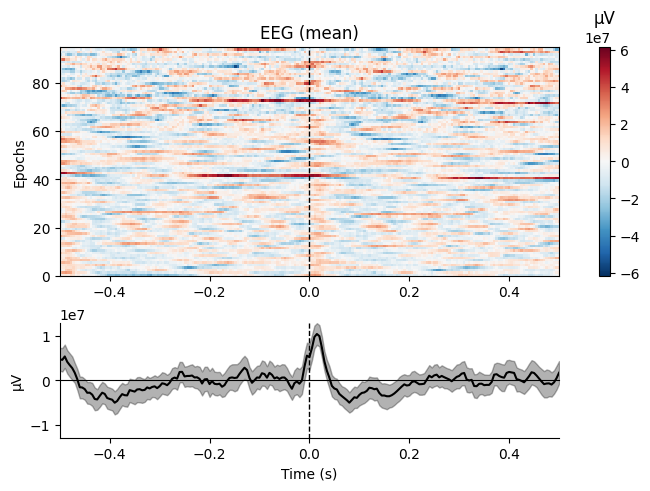

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 2.6s.


C:\Users\mccruz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


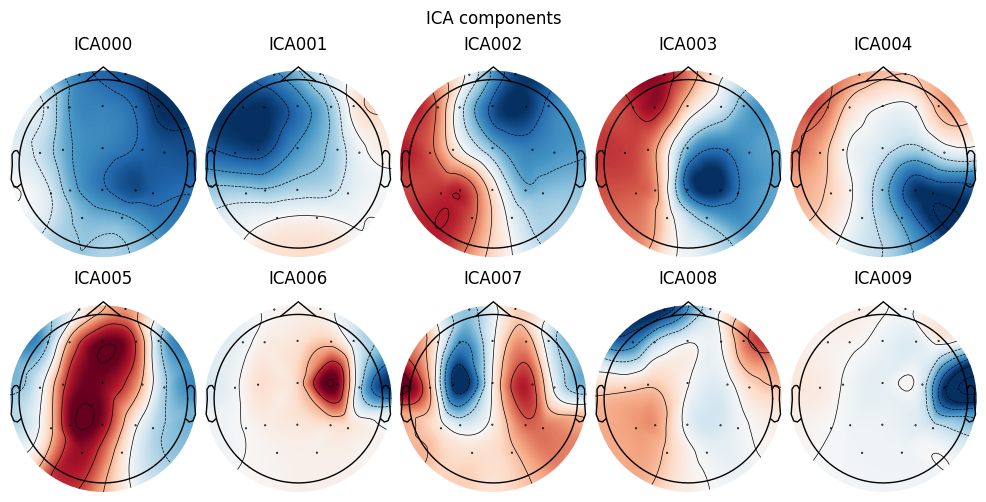

Using threshold: 0.36 for CTPS ECG detection
Using channel EKG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2000 samples (10.000 s)

Number of ECG events detected : 96 (average pulse 115 / min.)
Not setting metadata
96 matching events found
No baseline correction applied
Using data from preloaded Raw for 96 events and 201 original time points ...
1 bad epochs dropped


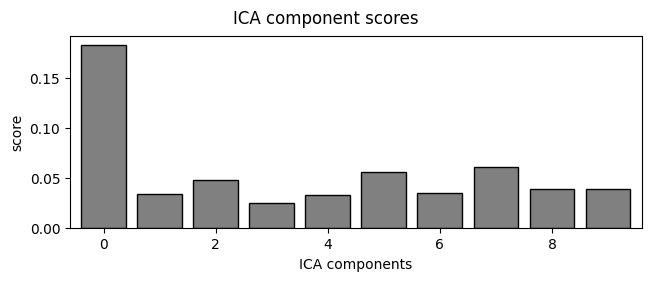

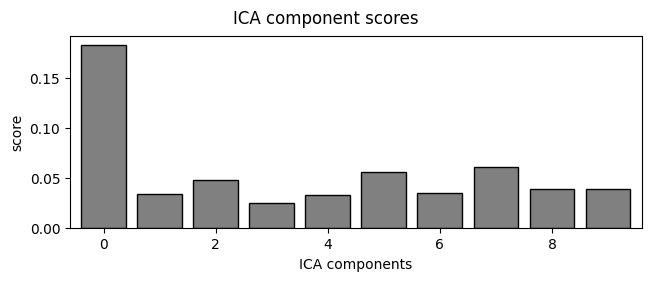

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\mccruz\AppData\Local\Temp\1\ipykernel_13124\4135001284.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final_data['eeg_filt'][i] = raw_final_filt.get_data()


combining channels using "mean"


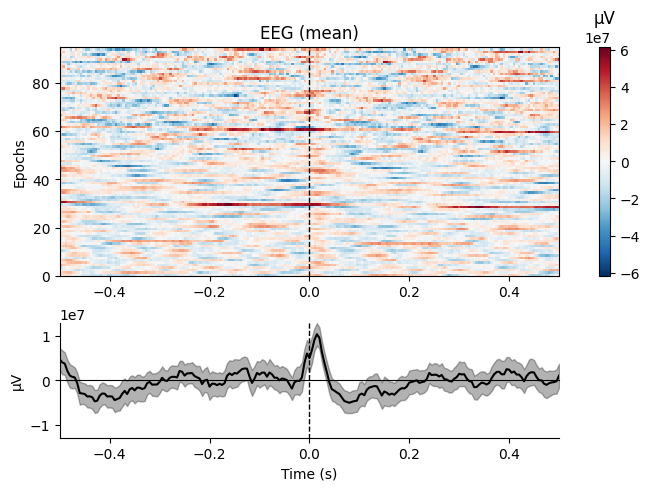

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.2s.


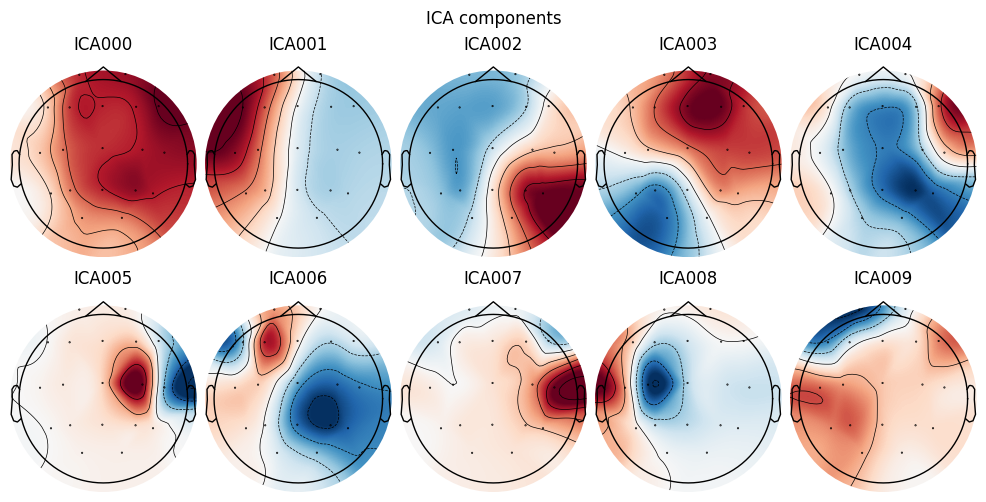

Using threshold: 0.36 for CTPS ECG detection
Using channel EKG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2000 samples (10.000 s)

Number of ECG events detected : 96 (average pulse 115 / min.)
Not setting metadata
96 matching events found
No baseline correction applied
Using data from preloaded Raw for 96 events and 201 original time points ...
1 bad epochs dropped


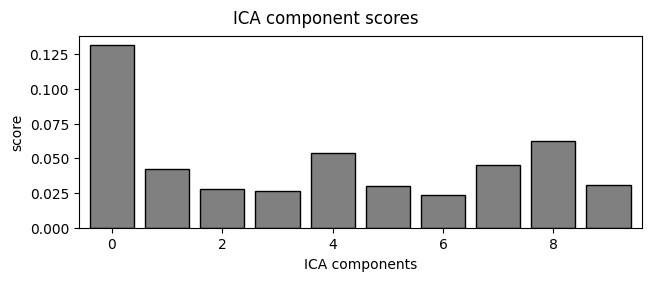

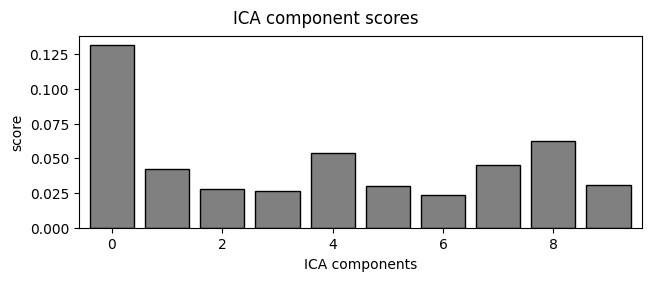

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\mccruz\AppData\Local\Temp\1\ipykernel_13124\4135001284.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final_data['eeg_filt'][i] = raw_final_filt.get_data()


In [59]:

for i in range(2): #range(len(train_final_data['eeg']))
    Xnp = train_final_data['eeg'][i]

    raw = mne.io.RawArray(data=Xnp.T, info=info, verbose=False);
    raw.set_montage('standard_1005', on_missing='warn');

    # Low-pass and High-pass Filters
    raw_filt = raw.copy().filter(0.5,80,verbose=False);

    ## TODO: Check this (not doing anything)
    ssp_projectors = raw_filt.info["projs"];
    raw_filt.del_proj();

    # ECG Summary Plot
    ecg_epochs = mne.preprocessing.create_ecg_epochs(raw_filt);
    ecg_epochs.plot_image(combine="mean");

    # ICA
    ica = mne.preprocessing.ICA(n_components=10, random_state=97); #change n_components
    ica.fit(raw_filt);
    ica.plot_components();

    # For ECG artifacts
    ecg_indices, ecg_scores = ica.find_bads_ecg(raw_filt); #, ecg_events=ecg_events)
    ica.plot_scores(ecg_scores);
    ica.exclude.extend(ecg_indices)
    ica.plot_scores(ecg_scores);

    raw_ica = ica.apply(raw_filt);

    # Notch Filters
    raw_final_filt = raw_ica.notch_filter(freqs=50, filter_length='auto', phase='zero')
    raw_final_filt = raw_final_filt.notch_filter(freqs=60, filter_length='auto', phase='zero')


    train_final_data['eeg_filt'][i] = raw_final_filt.get_data()


    #raw.plot(scalings='auto');

    #fig = raw.compute_psd(tmax=np.inf, fmax=100).plot(average=True, picks="data", exclude="bads")
    # add some arrows at 60 Hz and its harmonics:
    #for ax in fig.axes[1:]:
    #    freqs = ax.lines[-1].get_xdata()
    #    psds = ax.lines[-1].get_ydata()
    #    for freq in (60, 120, 180, 240):
    #        idx = np.searchsorted(freqs, freq)
    #        ax.arrow(
    #            x=freqs[idx],
    #            y=psds[idx] + 18,
    #            dx=0,
    #            dy=-12,
    #            color="red",
    #            width=0.1,
    #            head_width=3,
    #            length_includes_head=True,
    #        )
    #plt.show()

    #raw_filt.plot(scalings='auto');
    #raw_final_filt.plot(scalings='auto');
    #ica.plot_sources(raw, show_scrollbars=False, show=True);

In [60]:
train_final_data

expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0               Seizure             3         0         0          0   
1               Seizure             3         0         0          0   
2               Seizure             3         0         0          0   
3               Seizure             3         0         0          0   
4               Seizure             3         0         0          0   
...                 ...           ...       ...       ...        ...   
106795             LRDA             0         0         0          3   
106796             LRDA             0         0         0          3   
106797             LRDA             0         0         0          3   
106798             LRDA             0         0         0          3   
106799             LRDA             0         0         0          3   

        grda_vote  other_vote  \
0               0           0   
1               0           0   
2               0           0   
3               0           0   
4               0           0   
...           ...         ...   
106795          0           0   
106796          0           0   
106797          0           0   
106798          0           0   
106799          0           0   

                                                      eeg  \
0       [[-80.52, -70.54, -80.11, -108.75, -120.33, -8...   
1       [[-129.46, -115.58, -115.13, -157.44, -166.98,...   
2       [[-78.44, -91.23, -95.89, -122.52, -82.95, -10...   
3       [[-138.52, -147.82, -139.91, -163.32, -174.93,...   
4       [[-100.36, -131.58, -123.24, -143.03, -92.76, ...   
...                                                   ...   
106795  [[-132.86, -62.49, -32.34, -38.95, -55.89, -48...   
106796  [[-30.78, 7.31, 35.17, 10.64, 26.54, 8.21, -12...   
106797  [[-21.89, -23.73, 1.45, -13.61, 3.53, -8.35, -...   
106798  [[-104.02, -11.17, 33.22, 16.19, -33.65, -2.75...   
106799  [[-62.91, -24.75, 8.54, -6.68, -17.55, -21.73,...   

                                                 eeg_filt  
0       [[1.4210854715202004e-14, -0.2792937841829186,...  
1       [[-4.263256414560601e-14, 0.47885377462003476,...  
2                                                          
3                                                          
4                                                          
...                                                   ...  
106795                                                     
106796                                                     
106797                                                     
106798                                                     
106799                                                     

[106800 rows x 9 columns]

## Visualization (Not updated)

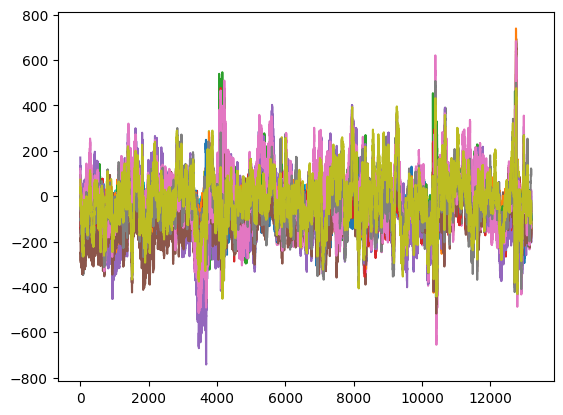

In [ ]:
plt.plot(eeg2)
plt.show()

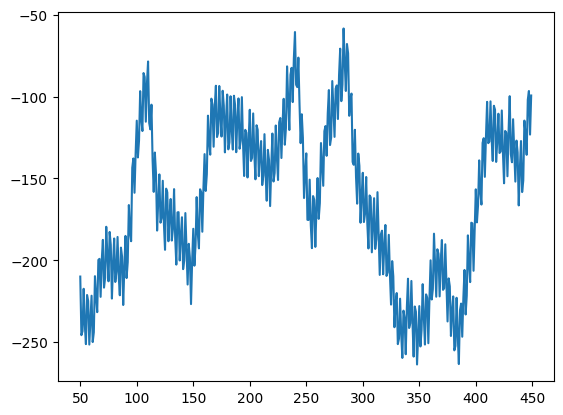

In [ ]:
plt.plot(eeg2['Fp1'][50:450])
plt.show()

In [119]:
spect2 = pd.read_parquet('train_spectrograms/353733.parquet')

In [116]:
spect2 = spect2.drop('time', axis=1)

In [120]:
spect2

time  LL_0.59  LL_0.78  LL_0.98  LL_1.17  LL_1.37    LL_1.56    LL_1.76  \
0       1     4.26    10.98     9.05    13.65    11.49   8.930000  18.840000   
1       3     2.65     3.97    12.18    13.26    14.21  13.230000   9.650000   
2       5     4.18     4.53     8.77    14.26    13.36  16.559999  19.219999   
3       7     2.41     3.21     4.92     8.07     5.97  12.420000  10.820000   
4       9     2.29     2.44     2.77     4.62     5.39   7.080000   9.840000   
..    ...      ...      ...      ...      ...      ...        ...        ...   
315   631     6.36     6.59     6.60     7.30     4.48   8.400000  13.420000   
316   633     4.90     8.80     8.22     5.83    10.21  10.580000  10.250000   
317   635     6.07     7.85    11.26     9.20     8.18   9.130000  10.450000   
318   637     3.41     3.75     4.80     6.45     6.70   7.960000   8.160000   
319   639     2.88     3.71     4.02     6.07     5.63   5.460000   6.270000   

     LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  \
0      19.26  19.240000  ...      0.31      0.17      0.28      0.19   
1       8.11  11.280000  ...      0.15      0.13      0.14      0.24   
2      17.51  22.650000  ...      0.29      0.21      0.16      0.25   
3      14.96  21.809999  ...      0.33      0.51      0.49      0.64   
4      12.27  14.410000  ...      0.44      0.38      0.48      0.63   
..       ...        ...  ...       ...       ...       ...       ...   
315    13.85  16.010000  ...      0.14      0.05      0.06      0.04   
316    13.68  19.549999  ...      0.16      0.08      0.06      0.06   
317    15.09  23.020000  ...      0.15      0.13      0.13      0.13   
318     6.97   9.700000  ...      0.13      0.11      0.13      0.07   
319     4.99   6.220000  ...      0.16      0.13      0.14      0.16   

     RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0        0.24      0.27      0.29      0.16      0.22      0.19  
1        0.24      0.36      0.35      0.31      0.36      0.40  
2        0.28      0.28      0.34      0.48      0.44      0.48  
3        0.58      0.42      0.32      0.31      0.32      0.33  
4        0.45      0.45      0.49      0.33      0.31      0.34  
..        ...       ...       ...       ...       ...       ...  
315      0.04      0.04      0.05      0.05      0.08      0.11  
316      0.07      0.04      0.06      0.09      0.07      0.08  
317      0.10      0.08      0.07      0.09      0.17      0.12  
318      0.11      0.12      0.09      0.16      0.19      0.19  
319      0.12      0.12      0.11      0.09      0.07      0.05  

[320 rows x 401 columns]

<Axes: >

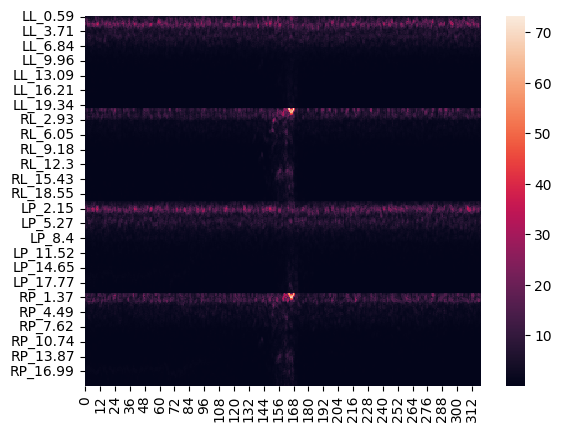

In [117]:
sns.heatmap(spect2.T)

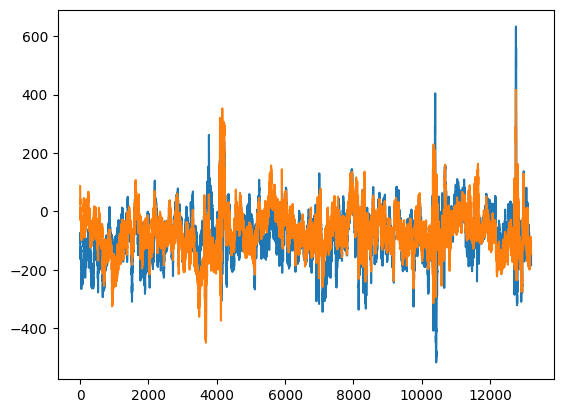

In [ ]:
plt.plot(spect['Fp1'])
plt.plot(spect['F3'])
plt.show()

In [ ]:
eg = pd.read_parquet('train_eegs/642382.parquet')

In [ ]:
for i in range(10):
    egoff = eg.iloc[i*200:(i+50)*200]

In [ ]:
eg#.iloc[i*200:(i+50)*200]

Fp1         F3         C3         P3     F7         T3  \
0     -20.170000  16.240000 -26.139999 -17.610001  -9.73 -40.160000   
1     -19.639999  19.309999 -22.790001 -13.880000  -9.27 -36.630001   
2     -16.320000  19.760000 -22.299999 -14.820000 -14.61 -38.139999   
3     -20.090000  20.520000 -21.580000 -14.420000 -14.38 -38.369999   
4     -20.190001  25.879999 -15.450000 -11.530000  -4.92 -35.730000   
...          ...        ...        ...        ...    ...        ...   
14795  34.970001  32.029999 -39.310001 -38.060001  16.01 -38.849998   
14796  33.910000  31.500000 -39.959999 -38.259998  12.62 -38.360001   
14797  33.680000  31.830000 -41.410000 -40.060001  14.91 -37.270000   
14798  33.689999  30.889999 -44.439999 -43.700001  13.21 -41.299999   
14799  33.639999  28.469999 -55.950001 -44.590000   9.94 -38.740002   

              T5         O1         Fz         Cz         Pz        Fp2  \
0     -31.740000 -34.310001   0.340000   1.170000  -7.860000 -14.430000   
1     -28.160000 -31.490000   2.730000   2.880000  -7.610000 -11.440000   
2     -32.240002 -38.349998   2.450000  -2.120000 -12.240000 -11.880000   
3     -32.080002 -38.610001   2.860000  -4.620000 -13.800000 -11.740000   
4     -30.260000 -38.189999   4.700000  -3.450000 -14.680000 -10.980000   
...          ...        ...        ...        ...        ...        ...   
14795 -43.759998 -59.240002  15.040000 -28.040001 -51.750000  35.220001   
14796 -38.919998 -56.459999  15.320000 -27.240000 -50.330002  35.490002   
14797 -39.320000 -57.290001  16.420000 -25.200001 -50.930000  35.189999   
14798 -44.270000 -62.779999  16.450001 -28.160000 -53.639999  36.470001   
14799 -44.439999 -61.959999  16.080000 -27.680000 -51.099998  40.180000   

              F4          C4         P4         F8         T4         T6  \
0     -24.330000 -199.250000   3.540000 -23.879999 -24.370001 -22.080000   
1     -23.389999  -43.990002   1.570000 -23.770000 -26.080000 -22.870001   
2     -25.830000  193.460007  -6.550000 -27.340000 -32.209999 -29.680000   
3     -25.209999 -109.419998  -9.180000 -25.969999 -32.270000 -30.440001   
4     -25.080000 -175.009995 -12.640000 -27.950001 -36.700001 -35.000000   
...          ...         ...        ...        ...        ...        ...   
14795 -13.280000  173.919998 -53.930000   1.450000 -36.660000 -54.549999   
14796 -11.490000 -151.449997 -52.540001   3.110000 -33.570000 -50.849998   
14797  -9.520000 -115.919998 -51.520000   6.640000 -30.400000 -50.369999   
14798 -10.580000  200.860001 -55.160000   4.480000 -34.119999 -55.540001   
14799  -6.880000  -30.790001 -52.770000   8.190000 -32.320000 -53.529999   

              O2        EKG  
0      23.410000  22.309999  
1      22.590000  29.100000  
2      15.090000  19.610001  
3      13.150000  22.299999  
4       9.120000  33.080002  
...          ...        ...  
14795 -21.180000  -1.070000  
14796 -19.100000  10.430000  
14797 -18.580000  10.740000  
14798 -23.790001  -0.820000  
14799 -21.080000   3.570000  

[14800 rows x 20 columns]

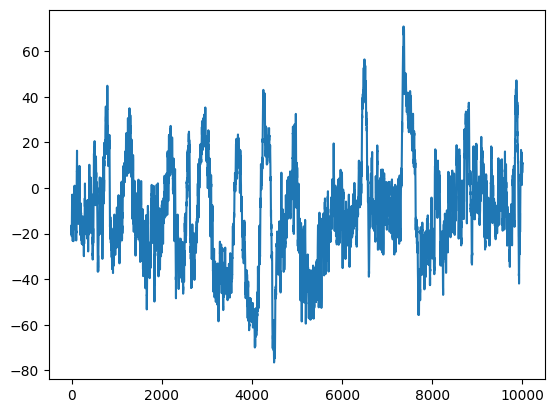

In [ ]:
for i in range(1):
    plt.plot(np.arange(0,10000),eg.iloc[i*200:(10*i+50)*200]['Fp1'])
    plt.show()

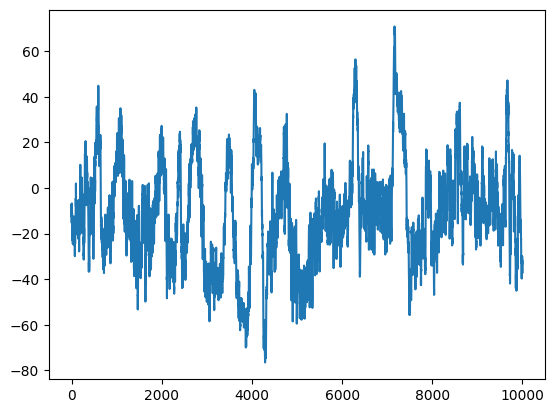

In [ ]:
plt.plot(np.arange(0,10000),eg.iloc[1*200:(1+50)*200]['Fp1'])

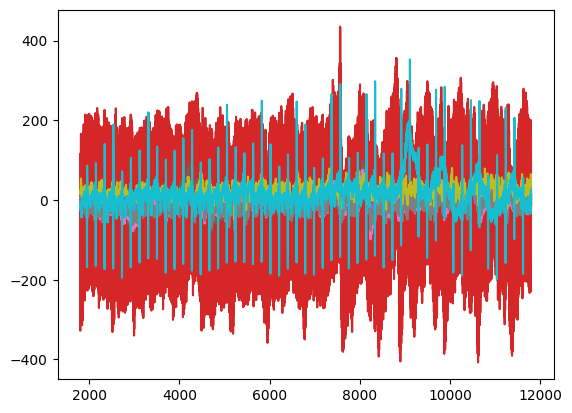

In [ ]:
plt.plot(egoff)
plt.show()

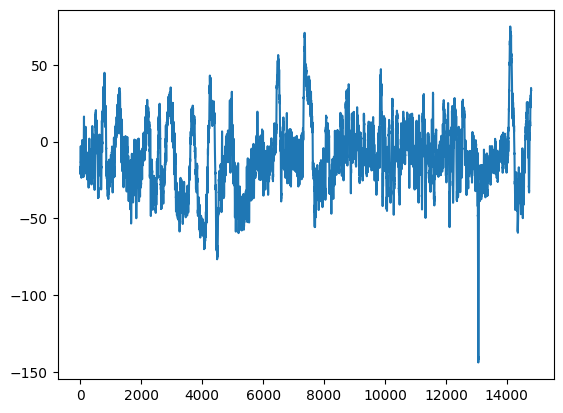

In [ ]:
plt.plot(eg['Fp1'])

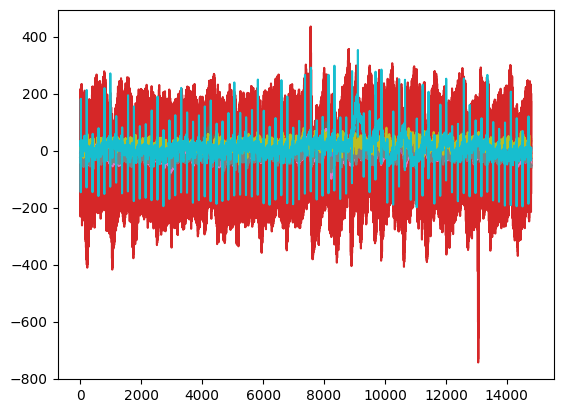

In [ ]:
plt.plot(eg)
plt.show()

In [ ]:
pd.read_parquet('train_spectrograms/353733.parquet')

time  LL_0.59  LL_0.78  LL_0.98  LL_1.17  LL_1.37    LL_1.56    LL_1.76  \
0       1     4.26    10.98     9.05    13.65    11.49   8.930000  18.840000   
1       3     2.65     3.97    12.18    13.26    14.21  13.230000   9.650000   
2       5     4.18     4.53     8.77    14.26    13.36  16.559999  19.219999   
3       7     2.41     3.21     4.92     8.07     5.97  12.420000  10.820000   
4       9     2.29     2.44     2.77     4.62     5.39   7.080000   9.840000   
..    ...      ...      ...      ...      ...      ...        ...        ...   
315   631     6.36     6.59     6.60     7.30     4.48   8.400000  13.420000   
316   633     4.90     8.80     8.22     5.83    10.21  10.580000  10.250000   
317   635     6.07     7.85    11.26     9.20     8.18   9.130000  10.450000   
318   637     3.41     3.75     4.80     6.45     6.70   7.960000   8.160000   
319   639     2.88     3.71     4.02     6.07     5.63   5.460000   6.270000   

     LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  \
0      19.26  19.240000  ...      0.31      0.17      0.28      0.19   
1       8.11  11.280000  ...      0.15      0.13      0.14      0.24   
2      17.51  22.650000  ...      0.29      0.21      0.16      0.25   
3      14.96  21.809999  ...      0.33      0.51      0.49      0.64   
4      12.27  14.410000  ...      0.44      0.38      0.48      0.63   
..       ...        ...  ...       ...       ...       ...       ...   
315    13.85  16.010000  ...      0.14      0.05      0.06      0.04   
316    13.68  19.549999  ...      0.16      0.08      0.06      0.06   
317    15.09  23.020000  ...      0.15      0.13      0.13      0.13   
318     6.97   9.700000  ...      0.13      0.11      0.13      0.07   
319     4.99   6.220000  ...      0.16      0.13      0.14      0.16   

     RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0        0.24      0.27      0.29      0.16      0.22      0.19  
1        0.24      0.36      0.35      0.31      0.36      0.40  
2        0.28      0.28      0.34      0.48      0.44      0.48  
3        0.58      0.42      0.32      0.31      0.32      0.33  
4        0.45      0.45      0.49      0.33      0.31      0.34  
..        ...       ...       ...       ...       ...       ...  
315      0.04      0.04      0.05      0.05      0.08      0.11  
316      0.07      0.04      0.06      0.09      0.07      0.08  
317      0.10      0.08      0.07      0.09      0.17      0.12  
318      0.11      0.12      0.09      0.16      0.19      0.19  
319      0.12      0.12      0.11      0.09      0.07      0.05  

[320 rows x 401 columns]

0         train_eegs/1628180742.parquet
1         train_eegs/1628180742.parquet
2         train_eegs/1628180742.parquet
3         train_eegs/1628180742.parquet
4         train_eegs/1628180742.parquet
                      ...              
106795     train_eegs/351917269.parquet
106796     train_eegs/351917269.parquet
106797     train_eegs/351917269.parquet
106798     train_eegs/351917269.parquet
106799     train_eegs/351917269.parquet
Name: eeg_path, Length: 106800, dtype: object

In [ ]:
df.iloc[9:11]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
9   2277392603           0                       0.0          924234   
10  2277392603           1                       2.0          924234   

    spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
9                    0                               0.0  1978807404   
10                   1                               2.0   134339127   

    patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
9        30539              GPD             0         0         5          0   
10       30539              GPD             0         0         5          0   

    grda_vote  other_vote                       eeg_path  \
9           1           5  train_eegs/2277392603.parquet   
10          1           5  train_eegs/2277392603.parquet   

                            spec_path class_name  
9   train_spectrograms/924234.parquet        GPD  
10  train_spectrograms/924234.parquet        GPD

In [ ]:
df.iloc[22:30]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
22   387987538           0                       0.0         1084844   
23   387987538           1                       2.0         1084844   
24   387987538           2                       6.0         1084844   
25   387987538           3                       8.0         1084844   
26   387987538           4                      10.0         1084844   
27   387987538           5                      12.0         1084844   
28  2175806584           0                       0.0         1219001   
29  2175806584           1                      18.0         1219001   

    spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
22                   0                               0.0  4099147263   
23                   1                               2.0  2049177862   
24                   2                               6.0  2799003238   
25                   3                               8.0  4095182959   
26                   4                              10.0   945645156   
27                   5                              12.0  4265938906   
28                   0                               0.0  1963161945   
29                   1                              18.0    26544501   

    patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
22        4264             LRDA             0         0         0          3   
23        4264             LRDA             0         0         0          3   
24        4264             LRDA             0         0         0          3   
25        4264             LRDA             0         0         0          3   
26        4264             LRDA             0         0         0          3   
27        4264             LRDA             0         0         0          3   
28       23435          Seizure             3         0         0          0   
29       23435          Seizure             3         0         0          0   

    grda_vote  other_vote                       eeg_path  \
22          0           0   train_eegs/387987538.parquet   
23          0           0   train_eegs/387987538.parquet   
24          0           0   train_eegs/387987538.parquet   
25          0           0   train_eegs/387987538.parquet   
26          0           0   train_eegs/387987538.parquet   
27          0           0   train_eegs/387987538.parquet   
28          0           0  train_eegs/2175806584.parquet   
29          0           0  train_eegs/2175806584.parquet   

                             spec_path class_name  
22  train_spectrograms/1084844.parquet       LRDA  
23  train_spectrograms/1084844.parquet       LRDA  
24  train_spectrograms/1084844.parquet       LRDA  
25  train_spectrograms/1084844.parquet       LRDA  
26  train_spectrograms/1084844.parquet       LRDA  
27  train_spectrograms/1084844.parquet       LRDA  
28  train_spectrograms/1219001.parquet    Seizure  
29  train_spectrograms/1219001.parquet    Seizure

In [ ]:
sum(df['eeg_label_offset_seconds'] == df['spectrogram_label_offset_seconds'])

77239

In [ ]:
df2 = pd.read_csv(f'test.csv')

In [ ]:
df2

spectrogram_id      eeg_id  patient_id
0          853520  3911565283        6885

In [ ]:
df['expert_consensus'].unique()

array(['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD'], dtype=object)